# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [7]:
loss

array([2.37741395, 2.34801876, 2.35386761, 2.39304463, 2.35933181,
       2.36117248, 2.35124258, 2.38386322, 2.35613378, 2.38653479])

In [8]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.357421
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [9]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.670677 analytic: 1.670677, relative error: 3.980879e-08
numerical: 3.107106 analytic: 3.107106, relative error: 5.904318e-09
numerical: 0.862879 analytic: 0.862879, relative error: 6.053812e-08
numerical: 0.617829 analytic: 0.617829, relative error: 3.294499e-08
numerical: -0.162353 analytic: -0.162353, relative error: 1.100372e-07
numerical: 1.016685 analytic: 1.016685, relative error: 2.621842e-08
numerical: 2.492703 analytic: 2.492703, relative error: 1.563829e-08
numerical: -4.991760 analytic: -4.991760, relative error: 3.595557e-09
numerical: 1.775106 analytic: 1.775106, relative error: 3.706561e-08
numerical: 0.255255 analytic: 0.255255, relative error: 2.448130e-08
numerical: -0.677829 analytic: -0.677829, relative error: 2.848476e-08
numerical: 1.837153 analytic: 1.837153, relative error: 1.016511e-09
numerical: 1.753365 analytic: 1.753365, relative error: 5.196685e-09
numerical: 1.209926 analytic: 1.209926, relative error: 4.056622e-08
numerical: -1.703579 analyti

In [70]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.357421e+00 computed in 0.238126s
vectorized loss: 2.357421e+00 computed in 0.004992s
Loss difference: 0.000000
Gradient difference: 0.000000


In [74]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = np.logspace(-7, -1, 6)
regularization_strengths = np.logspace(-2, 2, 5)

for alpha in learning_rates:
    for lmbda in regularization_strengths:
        sm = Softmax()
        sm.train(X_train, y_train, learning_rate=alpha, reg=lmbda, num_iters=500, verbose=True)
        y_train_pred = np.mean(y_train == sm.predict(X_train))
        y_val_pred = np.mean(y_val == sm.predict(X_val))
        if best_val < y_val_pred:
            best_val = y_val_pred
            best_softmax = sm
        results[(alpha, lmbda)] = (y_train_pred, y_val_pred)
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 500: loss 5.910724
iteration 100 / 500: loss 4.181595
iteration 200 / 500: loss 3.734169
iteration 300 / 500: loss 3.498546
iteration 400 / 500: loss 3.372826
iteration 0 / 500: loss 6.353160
iteration 100 / 500: loss 4.199834
iteration 200 / 500: loss 3.037015
iteration 300 / 500: loss 3.608911
iteration 400 / 500: loss 3.002842
iteration 0 / 500: loss 5.364734
iteration 100 / 500: loss 4.227436
iteration 200 / 500: loss 3.571434
iteration 300 / 500: loss 3.423583
iteration 400 / 500: loss 3.283322
iteration 0 / 500: loss 5.172079
iteration 100 / 500: loss 3.992953
iteration 200 / 500: loss 3.868817
iteration 300 / 500: loss 3.696231
iteration 400 / 500: loss 3.660884
iteration 0 / 500: loss 8.187427
iteration 100 / 500: loss 7.246986
iteration 200 / 500: loss 6.754480
iteration 300 / 500: loss 6.566438
iteration 400 / 500: loss 6.605058
iteration 0 / 500: loss 5.685614
iteration 100 / 500: loss 2.459356
iteration 200 / 500: loss 2.185692
iteration 300 / 500: loss 2.1186

C:\Users\bllgu\Documents\repos\cs231n\assignment1\cs231n\classifiers\softmax.py:68: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-correct_class_scores + np.log(np.sum(scores, axis=1)))


iteration 100 / 500: loss inf
iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss inf
iteration 0 / 500: loss 4.805316
iteration 100 / 500: loss 90.535516
iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss 85.755217
iteration 0 / 500: loss 4.766557
iteration 100 / 500: loss inf
iteration 200 / 500: loss inf
iteration 300 / 500: loss 89.173695
iteration 400 / 500: loss inf
iteration 0 / 500: loss 6.071915
iteration 100 / 500: loss inf
iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss 105.473985
iteration 0 / 500: loss 8.802273
iteration 100 / 500: loss inf
iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss inf
iteration 0 / 500: loss 5.332275
iteration 100 / 500: loss inf
iteration 200 / 500: loss inf
iteration 300 / 500: loss inf
iteration 400 / 500: loss inf
iteration 0 / 500: loss 5.828082
iteration 100 / 500: loss inf
iteration 200 / 500: loss i

C:\Users\bllgu\Documents\repos\cs231n\assignment1\cs231n\classifiers\softmax.py:79: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)
C:\Users\bllgu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\bllgu\Documents\repos\cs231n\assignment1\cs231n\classifiers\softmax.py:79: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)


iteration 200 / 500: loss inf


C:\Users\bllgu\Documents\repos\cs231n\assignment1\cs231n\classifiers\softmax.py:66: RuntimeWarning: overflow encountered in subtract
  scores -= np.max(scores)
C:\Users\bllgu\Documents\repos\cs231n\assignment1\cs231n\classifiers\softmax.py:66: RuntimeWarning: invalid value encountered in subtract
  scores -= np.max(scores)
C:\Users\bllgu\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration 300 / 500: loss nan
iteration 400 / 500: loss nan
lr 1.000000e-07 reg 1.000000e-02 train accuracy: 0.190469 val accuracy: 0.182000
lr 1.000000e-07 reg 1.000000e-01 train accuracy: 0.204265 val accuracy: 0.218000
lr 1.000000e-07 reg 1.000000e+00 train accuracy: 0.194612 val accuracy: 0.208000
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.204102 val accuracy: 0.202000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.200796 val accuracy: 0.193000
lr 1.584893e-06 reg 1.000000e-02 train accuracy: 0.323102 val accuracy: 0.313000
lr 1.584893e-06 reg 1.000000e-01 train accuracy: 0.320490 val accuracy: 0.308000
lr 1.584893e-06 reg 1.000000e+00 train accuracy: 0.316980 val accuracy: 0.304000
lr 1.584893e-06 reg 1.000000e+01 train accuracy: 0.318163 val accuracy: 0.303000
lr 1.584893e-06 reg 1.000000e+02 train accuracy: 0.329592 val accuracy: 0.327000
lr 2.511886e-05 reg 1.000000e-02 train accuracy: 0.278755 val accuracy: 0.272000
lr 2.511886e-05 reg 1.000000e-01 train accuracy: 

In [75]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.315000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

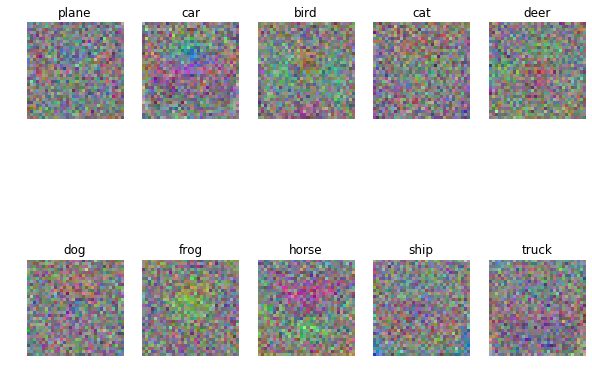

In [76]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])